In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np


#Select NVIDIA if available, otherwise cpu:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda:0")
#device = torch.device("cpu")

print(device)

cuda:0


In [2]:
#Common image transformations:
transform = transforms.Compose(
    #convert PIL image to tensor array:
    [transforms.ToTensor(),
    #each of the three pixel maps is centered to have mean 0.5 and std 0.5:
     transforms.Normalize((0.5,), (0.5,))])

#Download CIFAR data:
#root: where data to be stored, if not exists already
#train=True: data is used for training (otherwise test set is created)
#download=True: downloads data, if not exists in root already
#transform: applies transformations to image
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

#Dataloader makes dataset an iterable object
#batch_size: how many samples per batch to load
#shuffle: have data reshuffled at every epoch
#num_workers: how many subprocesses to use for data loading (0 means data is loaded into main process)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

#Load test data set:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
#Dataloader for test set:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

#Set classes:
#class_label[0]=plane, ..., class_label[9]=truck:
classes = (0,1,2,3,4,5,6,7,8,9)

In [3]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [4]:
trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [6]:
for i in np.unique(np.asarray(trainloader.dataset.targets)):
    print("Die Klasse {0} hat {1} Trainingsbilder und {2} Testbilder".format(i, (trainloader.dataset.targets == i).sum(), (testloader.dataset.targets == i).sum()))

Die Klasse 0 hat 5923 Trainingsbilder und 980 Testbilder
Die Klasse 1 hat 6742 Trainingsbilder und 1135 Testbilder
Die Klasse 2 hat 5958 Trainingsbilder und 1032 Testbilder
Die Klasse 3 hat 6131 Trainingsbilder und 1010 Testbilder
Die Klasse 4 hat 5842 Trainingsbilder und 982 Testbilder
Die Klasse 5 hat 5421 Trainingsbilder und 892 Testbilder
Die Klasse 6 hat 5918 Trainingsbilder und 958 Testbilder
Die Klasse 7 hat 6265 Trainingsbilder und 1028 Testbilder
Die Klasse 8 hat 5851 Trainingsbilder und 974 Testbilder
Die Klasse 9 hat 5949 Trainingsbilder und 1009 Testbilder


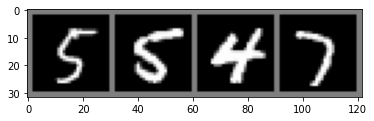

5     5     4     7


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#Get some random training images:
#Make trainloader iteraterable (over batches, so 4 images are fetched): 
dataiter = iter(trainloader)
#returns random next element:
images, labels = dataiter.next()

#Show images:
imshow(torchvision.utils.make_grid(images))
#Print labels:
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#images, labels = dataiter.next

In [8]:
#Define CNN architecture:

import torch.nn as nn
import torch.nn.functional as F

#Define Net as child class of nn.Module:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x


net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [9]:
#Define Loss function:

import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

In [10]:
%%time

#Training:
epochs = 2
loss = 0
log_interval = 10

#loop over the dataset "epochs" times:
for epoch in range(epochs):

    running_loss = 0.0
    #enumerate(trainloader,0): make trainloader iterable and start the index at 0:
    for i, data in enumerate(trainloader, 0):
        #get the inputs; data is a list of [inputs, labels]:
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs = inputs.view(-1, 28 * 28)
        
        #zero the parameter gradients (just to be save):
        optimizer.zero_grad()

        #forward:
        outputs = net(inputs)

        #loss += F.nll_loss(outputs, labels, reduction='sum').item()

        #loss:
        loss = criterion(outputs, labels)

        #backward:
        loss.backward()
        #optimize:
        optimizer.step()

        #print statistics:
        running_loss += loss.item()

        #loss /= len(trainloader.dataset)

        #print every 2000 mini-batches:
        if i % 2000 == 1999:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(data), len(trainloader.dataset), 100. * i / len(trainloader), running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Train Epoch: 0 [3998/60000 (13%)]	Loss: 0.742803
Train Epoch: 0 [7998/60000 (27%)]	Loss: 0.405635
Train Epoch: 0 [11998/60000 (40%)]	Loss: 0.305014
Train Epoch: 0 [15998/60000 (53%)]	Loss: 0.279381
Train Epoch: 0 [19998/60000 (67%)]	Loss: 0.248606
Train Epoch: 0 [23998/60000 (80%)]	Loss: 0.237571
Train Epoch: 0 [27998/60000 (93%)]	Loss: 0.222507
Train Epoch: 1 [3998/60000 (13%)]	Loss: 0.187698
Train Epoch: 1 [7998/60000 (27%)]	Loss: 0.184848
Train Epoch: 1 [11998/60000 (40%)]	Loss: 0.193160
Train Epoch: 1 [15998/60000 (53%)]	Loss: 0.166727
Train Epoch: 1 [19998/60000 (67%)]	Loss: 0.179984
Train Epoch: 1 [23998/60000 (80%)]	Loss: 0.170179
Train Epoch: 1 [27998/60000 (93%)]	Loss: 0.166872
Finished Training
CPU times: user 54 s, sys: 5.99 s, total: 1min
Wall time: 1min 3s


In [11]:
#Save trained model parameters:

PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [14]:
#Count correctly classified images of trained data set:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        
        images, labels = data[0].to(device), data[1].to(device)

        #do predicts on test set:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        #add the number of predicted images to "total", so we can keep track of how many images we have classified so far:
        total += labels.size(0)
        #add how many of the predicted labels are the same as the ground-truth labels:
        #(predicted == labels): predicted is tensor with integers, as well as labels; check if all integers are the same
        #(predicted == labels).sum(): sum up of how many were the same
        #(predicted == labels).sum().item(): give that number as a single value;
        #add it to the number of correctly classified instances:
        correct += (predicted == labels).sum().item()

#Print percentage of correctly classified instances:
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the test images: 95 %


In [16]:
#Classes that performed well vs. classes that did not perform well:

#Initialize lists pf ten values of 0.0:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        #do predictions on test set:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        #store correctly predicted classes (where prediction matches label) in "c":
        c = (predicted == labels)

        for i in range(4):
            label = labels[i]
            #count up how a certain class was predicted (true of false):
            class_correct[label] += c[i].item()
            #count up how often this class was predicted:
            class_total[label] += 1

#Print percentage of correctly classifications of each class:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 96 %
Accuracy of     3 : 96 %
Accuracy of     4 : 96 %
Accuracy of     5 : 93 %
Accuracy of     6 : 97 %
Accuracy of     7 : 94 %
Accuracy of     8 : 94 %
Accuracy of     9 : 92 %
